In [19]:
#### IMPORTS ####
# General data processing
library(dplyr)
library(ggplot2)
library(ggpubr)
library(janitor)
library(purrr)
library(rvest)
library(tidyr)

# Text analysis
library(quanteda)
library(stringr)
library(tidytext)

# Wordclouds
library(htmlwidgets)
library(magick)
library(webshot)
library(wordcloud2)

# Conflict management
library(conflicted)
conflict_prefer('filter', 'dplyr')
conflict_prefer('lag', 'dplyr')

[conflicted] Removing existing preference

[conflicted] Will prefer dplyr::filter over any other package

[conflicted] Removing existing preference

[conflicted] Will prefer dplyr::lag over any other package



In [20]:
#### THEMING ####
library(IRdisplay)
theme_set(theme_light())
party_colours <- c('#0087DC', '#DC241f', '#FDBB30')

Party conferences are a mainstay in British politics whereby politicians, party members and affiliated people descend on a chosen city in order to set the party agenda, raise funds and attempt to get a soundbite into the mainstream media. The hallmark of these conferences are the Leaders' speeches, where the current head of the party aims to appeal to their party base or even attract some new voters through media coverage.

## Data Background

In [21]:
parties <- c(
    'Labour' = 4, 
    'Conservative' = 5,
    'Liberal Democrat' = 6
)
parties <- parties[order(names(parties))]
year_range <- c(2010, 2018)
base_url <- 'http://www.britishpoliticalspeech.org/'

speeches_text <- map2_dfr(parties, names(parties), ~{
    query <- paste0('Leader%27s+speech&party=', .x,
                    '&searchRangeFrom=', year_range[1],
                    '&searchRangeTo=', year_range[2])
    url <- paste0(base_url, 'speech-archive.htm?q=', query)
    
    speech_links <- read_html(url) %>%
        html_nodes(xpath = '//*[@id="main-content"]/div/div[2]/table/tbody/tr/td[4]/a') %>%
        html_attr('href')
    
    map_dfr(speech_links, ~{
        url <- paste0(base_url, .x)
        page <- read_html(url)
       
        year <- page %>%
            html_node('h3') %>%
            html_text() %>%
            str_extract(r"{\d{4}}") %>%
            as.integer()
        
        leader <- page %>%
            html_node('.speech-speaker') %>%
            html_text() %>%
            # Remove bracketed text (party name)
            str_remove(r"{\(.*\)}") %>%
            str_trim()
        
        text <- page %>%
            html_node('.speech-content') %>%
            html_text()
        
        tibble(year, leader, text)
    }) %>%
        mutate(party = .y) %>%
        select(party, everything())
})

speeches_words <- speeches_text %>%
    mutate(
        # Remove comma from large numbers (e.g. "55,000")
        text = str_replace_all(text, r"{([0-9]+),([0-9]+)}", r"{\\1\\2}"),
        # Replace apostrophe variants with true apostrophe
        text = str_replace_all(
            text,
            "\u0091|\u0092|\u0093|\u0094|\u0060|\u0027|\u2019|\u000A",
            "'"
        )
    ) %>%
    unnest_tokens(word, text)

This analysis would not have been possible without the transcripts provided by [British Political Speech](http://www.britishpoliticalspeech.org/speech-archive.htm). They describe themselves as "an online archive of British political speech and a place for the discussion, analysis, and critical appreciation of political rhetoric" and produce speeches dating back to 1895.

For my study, I aim to observe the nuances of party conference leadership speeches from 2010 to 2018. These dates were chosen as they coincide with a change in the British political landscape, following the 2010 election whilst still providing us with enough data to conduct meaningful analysis. For this study, I will only observe the three 'mainstay' political parties: the Conservatives, the Labour Party and the Liberal Democrats.

Upon importing and tidying the data, we can observe the 5 most used words within the speeches.

In [22]:
speeches_words %>%
    count(word, name = 'count') %>%
    top_n(5, count) %>%
    arrange(desc(count)) %>%
    clean_names('title')

Word,Count
<chr>,<int>
the,8777
to,5279
and,5033
of,3898
a,3470


There are no surprises here. In fact, the top 5 most used words here are from the top 6 most used words in the English language according to the [Oxford English Corpus](https://enacademic.com/dic.nsf/enwiki/2822326), a text corpus comprising over 2 billion words.

Carrying on our analysis with these common words would create a dull analysis, so to counteract this, we will temporarily remove them. We do this using the `tidytext` package in R, which contains a comprehensive list of [stop words](https://rdrr.io/cran/tidytext/man/stop_words.html). These are common words in the English language which would add nothing to certain parts of our analysis if they were to be included. A separate dataframe was created to store the non-stopwords which totalled 56,989 words, meaning that 105,883 words were removed.

In [23]:
speeches_words_cut <- speeches_words %>%
    anti_join(stop_words, by = 'word')

We can now observe the most used 5 non-stopwords.

In [24]:
speeches_words_cut %>%
    count(word, name = 'count') %>%
    top_n(5, count) %>%
    arrange(desc(count)) %>%
    clean_names('title')

Word,Count
<chr>,<int>
people,1207
country,684
government,598
party,577
britain,568


This is more like what we would have expected the vocabulary of a Leader's speech to look like.

We can go further and visualise the set of each party's 100 most commonly used non-stopwords through wordclouds. This is done below in each party's traditional colour. (Blue for Conservative, Red for Labour, Yellow for Liberal Democrat).

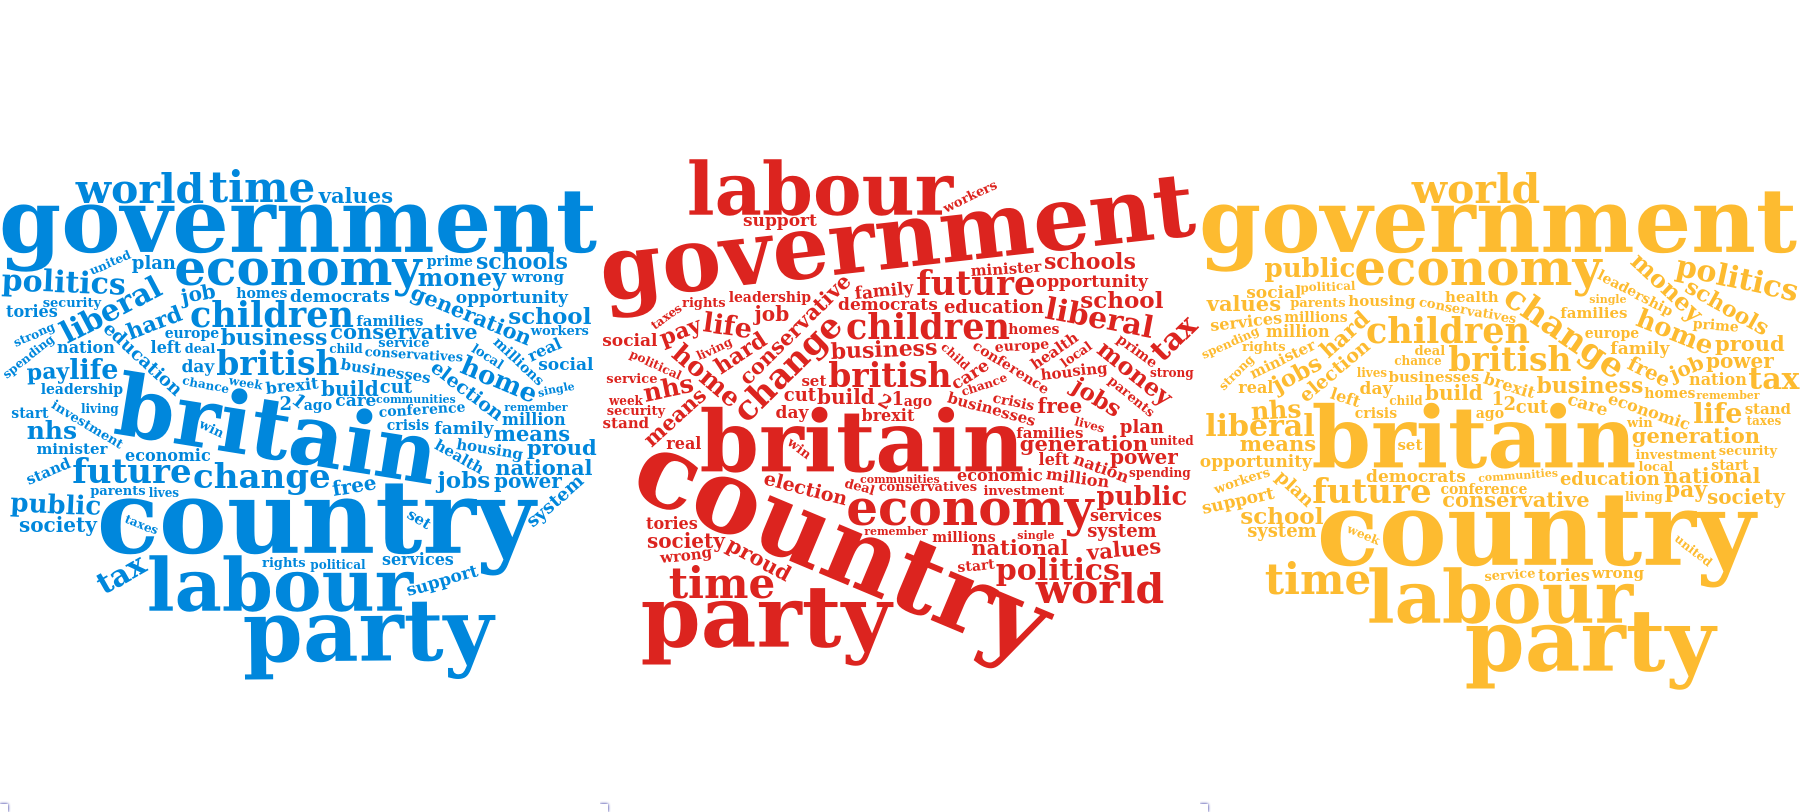

In [25]:
wc_images <- map2(names(parties), party_colours, ~{
    wc <- speeches_words_cut %>%
      count(word) %>%
      top_n(100, n) %>%
      wordcloud2(color = .y, shuffle = FALSE)
    saveWidget(wc, paste0(.x, '_wordcloud.html'), selfcontained = FALSE)
    # Need delay to ensure fully rendered image
    webshot(paste0(.x, '_wordcloud.html'), paste0(.x, '_wordcloud.png'),
                   vwidth = 600, vheight = 800, delay = 10)
    image_read(paste0(.x, '_wordcloud.png'))
})
               
combi_image <- image_append(image_join(wc_images))
image_write(combi_image, path = 'combi.png', format = 'png')
display_png(file = 'combi.png')

We can see that the words identified to be most common before appear most often in these wordclouds too (denoted by their large size). The only visible differences are the party's names, particularly visible for both Labour and the Liberal Democrats. Here we see the obvious flaws in word clouds, they barely allow us to observe any differences between the parties and provide no numerical insight. We will aim to address this weakness later with different methods.

Before we dive into some more detailed text analysis, we could have a quick exploration of the word count for each Leader's speech.

In [26]:
party_ids <- 1:length(parties)
names(party_ids) <- names(parties)

timeline <- speeches_text %>%
    group_by(party, leader) %>%
    # Assuming each leader has speeches for consecutive years only
    summarise(year_min = min(year), year_max = max(year), .groups = 'drop') %>%
    mutate(party_id = party_ids[party]) %>%
    ggplot() +
        geom_rect(aes(xmin = pmax(year_min - 0.45, year_range[1]),
                      xmax = pmin(year_max + 0.45, year_range[2]),
                      ymin = party_id - 0.4, ymax = party_id + 0.4,
                      fill = factor(party_id))) +
        geom_text(aes(x = (pmax(year_min - 0.45, year_range[1]) +
                           pmin(year_max + 0.45, year_range[2])) / 2, y = party_id,
                      label = leader, col = party == 'Liberal Democrat')) +
        scale_colour_manual(values = c('#ffffff', '#000000')) +
        scale_fill_manual(values = party_colours) +
        scale_y_continuous(labels = rep('', 3), breaks = 1:length(parties)) +
        labs(y = "", x = "") +
        theme(legend.position = 'none') +
        theme(axis.ticks.y = element_blank())

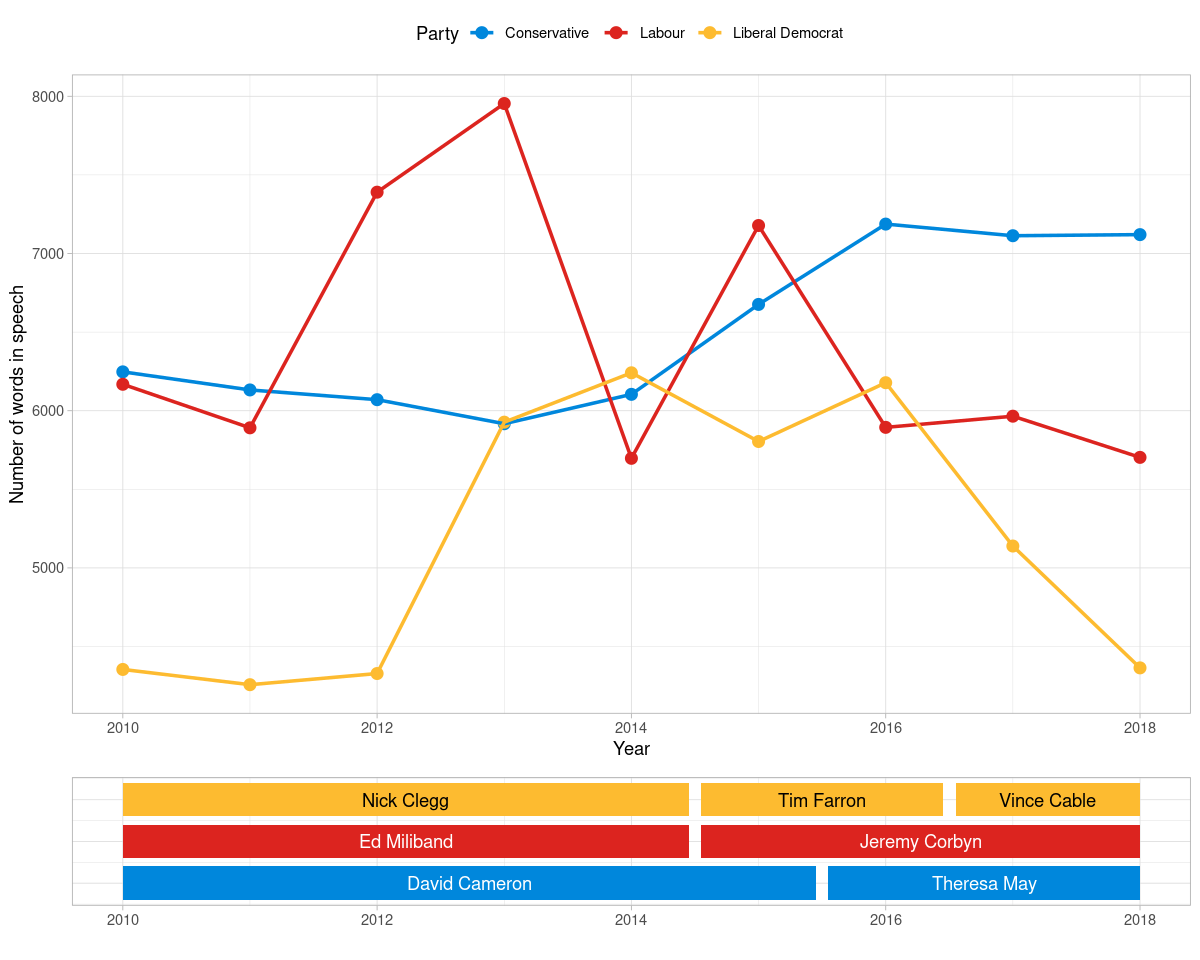

In [27]:
options(repr.plot.width = 10, repr.plot.height = 8)

word_count_plot <- speeches_words %>%
  count(party, year) %>%
    ggplot(aes(x = year, y = n, col=party)) +
    geom_point(size = 3) +
    geom_line(size = 1) +
    theme(legend.position = 'bottom')  + 
    labs(
        x = "Year",
        y = "Number of words in speech",
        col = "Party"
    ) +
    scale_colour_manual(values = party_colours) +
    theme(legend.position = 'top')

ggarrange(word_count_plot, timeline, ncol = 1, nrow = 2, heights = c(0.8, 0.2), align = 'v')

From this, we can see that Ed Miliband can be quite the rambler at times.

## Text Analysis

### Analysing Sentiment

Basic counts and summaries are great, but with modern data science techniques, we can go much further. For example, we can infer the sentiment (loosely, how positive or negative in tone) each speech is.

We do this by referencing the contents of each speech against the AFINN lexicon, created by Finn Arup Neilson. This lexicon assigns an integer value from -5 to 5 to a vast number English words with negative numbers indicating negative sentiment and positive numbers indicating positive sentiment. Here we list a random word for each sentiment value.

In [28]:
set.seed(123)
get_sentiments('afinn') %>%
    group_by(value) %>%
    sample_n(1) %>%
    clean_names('title')

Word,Value
<chr>,<dbl>
son-of-a-bitch,-5
fraudulence,-4
lunatics,-3
lethargy,-2
manipulation,-1
some kind,0
cool,1
courtesy,2
cheery,3


We can then take an average of the sentiments over all word in each speech and visualise it to see the trend of speech sentiment over time. This is conducted on the dataset with stopwords included, otherwise it could distort the sentiment (though note that most stopwords have a neutral sentiment).

In [29]:
speeches_sentiment <- speeches_words %>%
    inner_join(get_sentiments('afinn'), by = 'word')

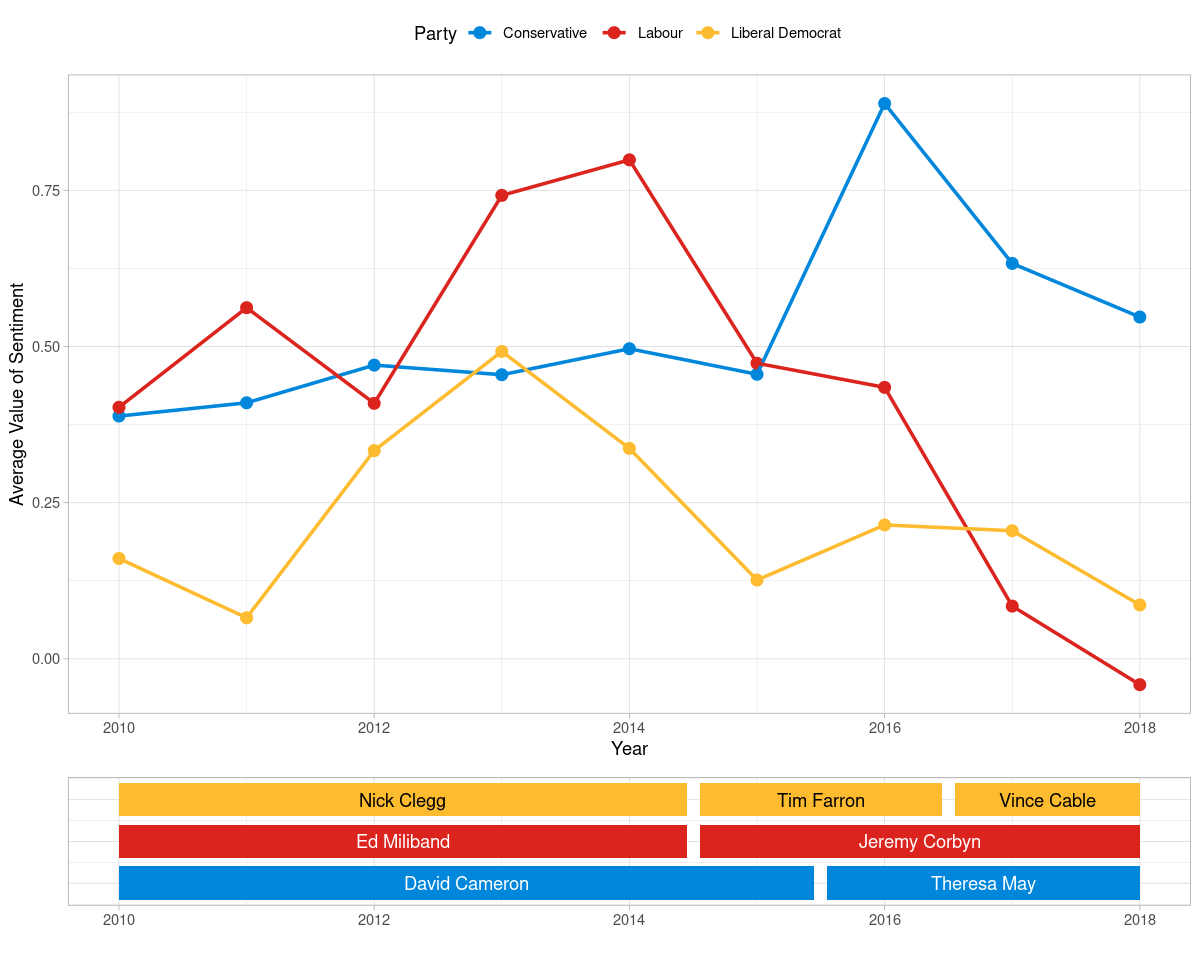

In [30]:
options(repr.plot.width = 10, repr.plot.height = 8)

sentiment_plot <- speeches_sentiment %>%
  group_by(party, year) %>%
  summarise(avg_sentiment = mean(value), .groups = 'drop') %>%
  ggplot(aes(x = year, y = avg_sentiment, col = party)) +
    geom_point(size = 3) +
    geom_line(size = 1) +
    labs(
        x = "Year",
        y = "Average Value of Sentiment",
        col = "Party"
    ) +
    scale_colour_manual(values = party_colours) +
    theme(legend.position = 'top')

ggarrange(sentiment_plot, timeline, ncol = 1, nrow = 2, heights = c(0.8, 0.2), align = 'v')

As we can see, the speeches are overwhelmingly positive, with the only negative score being Jeremy Corbyn's 2018 speech to the Labour Party conference. Other notable values include David Cameron's consistency between 2010 and 2015 for the Conservative Party and the significant jump in positivity when Theresa May took over the Conservative Leadership in 2016.

### Term Frequency and Zipf's Law

We have seen that raw word counts on their own aren't particularly useful. One flaw of many is that longer texts will naturally have higher word counts for all words. Instead, a more useful metric is how often a certain word (also called a term) appears as a proportion of all words. This is known as _term frequency_ and defined as

$$\text{Term Frequency} = \frac{\#\{\text{Occurrences of Term}\}}{\#\{\text{Occurrences of All Words}\}}$$

So that we can compare across parties, we will look at term frequencies as a proportion of the occurrences of each term in all speeches by the party the term came from. We start by looking at the distribution of term frequencies for each party.

In [31]:
speeches_tf <- speeches_words %>%
    count(party, word) %>%
    group_by(party) %>%
    mutate(tf = n / sum(n))

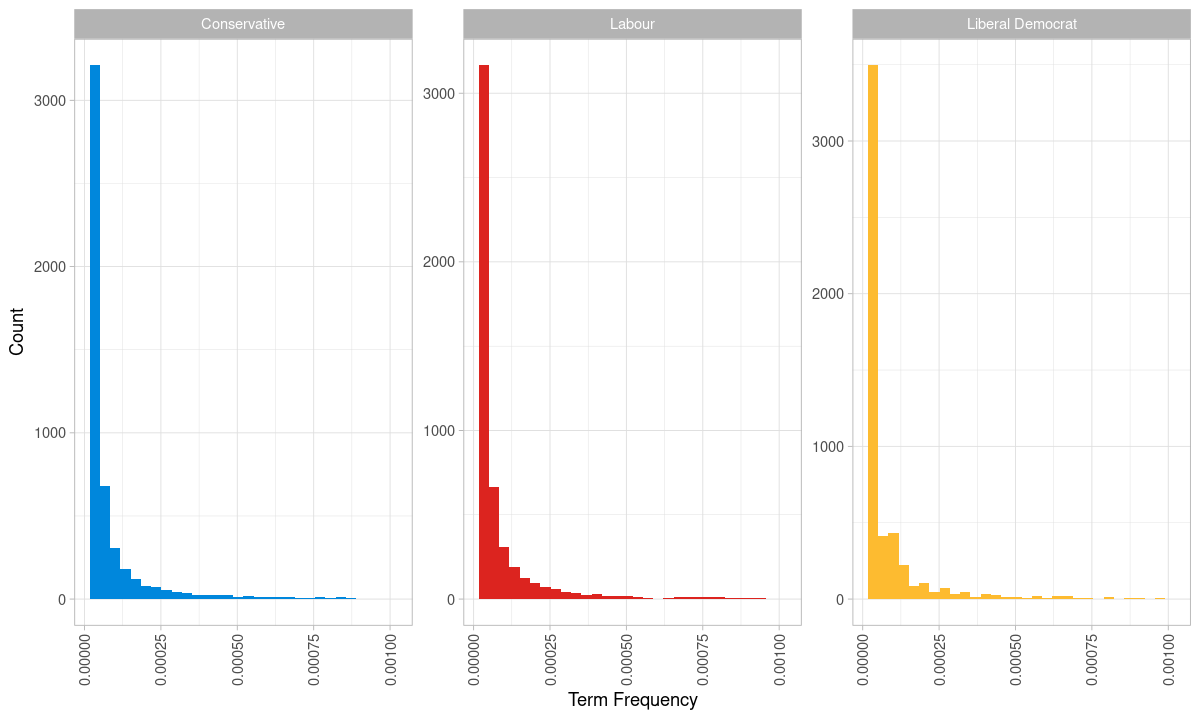

In [32]:
options(repr.plot.width = 10, repr.plot.height = 6)

speeches_tf %>%
  filter(tf < 0.001) %>%
  ggplot(aes(tf, fill = party)) +
    geom_histogram(show.legend = FALSE, bins = 30) +
    facet_wrap(~ party, nrow = 1, scales = "free_y") +
    labs(
        x = "Term Frequency",
        y = "Count",
        fill = "Party"
    ) +
    scale_fill_manual(values = party_colours) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) 

The plots all display a similar distribution for each party with many 'rare' words and fewer popular words.

It turns out that these long-tailed distributions are common in almost every occurrence of natural language. In fact, George Zipf, a 20th century American linguist created _Zipf's law_. This formalises the above observation, stating that the frequency that a word appears in a text is inversely proportional to its rank.

$$
\text{Term Frequency} \propto \frac{1}{\text{Rank}}
$$

Put simply, the most frequent word will appear at twice the rate of the second most frequent word and at three times that of the third most frequent word. 

Zipf's law is largely accurate for many natural languages, including English (though as always, there are exceptions). For example, in the Brown Corpus of American English text, which contains slightly over 1 million words: 'the' appears the most times at ~70000 times, 'of' the second most at ~36000 times and 'and' the third most at ~29000, as would be roughly expected according to Zipf's law.

We can attempt to visualise this law for our own text by plotting rank on the x-axis and term frequency on the y-axis, both on log scales.

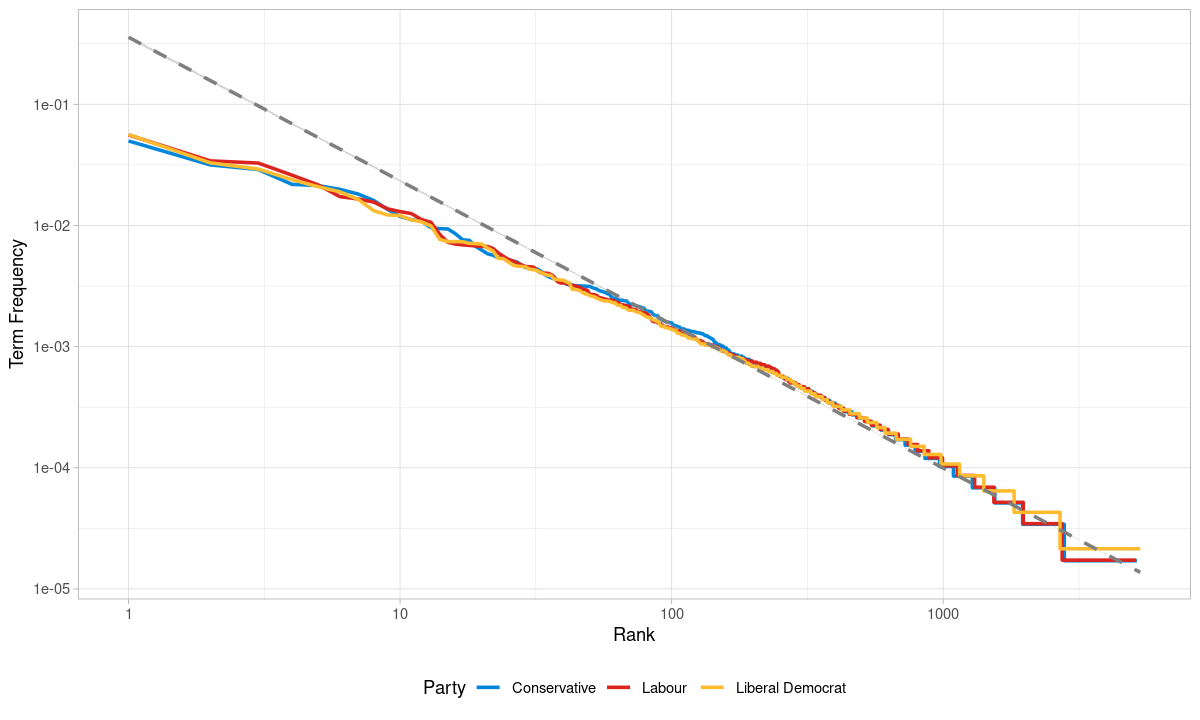

In [33]:
speeches_tf %>%
  group_by(party) %>%
  mutate(rank = row_number(-tf)) %>% 
  ggplot(aes(rank, tf)) + 
    geom_line(aes(color = party), size = 1) + 
    geom_smooth(method = 'lm', formula = y ~ x,
                size = 1, color = "gray50", linetype = 2) + 
    scale_x_log10() +
    scale_y_log10() +
    theme_light() + 
    theme(legend.position = 'bottom')  + 
    labs(
        x = "Rank",
        y = "Term Frequency",
        col = "Party"
    ) +
    scale_colour_manual(values = c('#0087DC', '#DC241f', '#FDBB30'))

We can see that all three parties have similar text structures largely obey Zipf's Law. That said, we can see that our curve deviates from a straight line at the lower rank tail, suggesting that the most popular words in the speeches are being used more often than they would in a natural language. Additionally, we would expect a slope of approximately $-1$; by fitting a linear model (shown in grey), we obtain a coefficient which is close to this value.

### TF-IDF Analysis

We've seen that we can use a list of stop words to filter our data to leave only meaningful words. However, this list is fixed and not linked to our data in any way. We've already seen that 'people' is used very commonly in our speeches and so doesn't provide that meaningful of an insight to us. Could construct a value that helped us to see the relative frequency of a term among our speeches, in order to see how important a word is to a specific speech compared to the others?

We can indeed. In fact the work has already been done for us in the form of a value value called the TF-IDF. It is calculated by multiplying the term frequency (TF) from earlier by a new value called the inverse document frequency (IDF).

$$TF\cdot{IDF} = \left(\frac{\#\{\text{Occurrences of Term}\}}{\#\{\text{Occurrences of All Words}\}}\right) \cdot \log \left(\frac{\#\{\text{Documents}\}}{\#\{\text{Documents Containing Term}\}}\right)$$

Loosely speaking, TF-IDF asks two questions:
- Is the specific term used more than expected in a given speech?
- Is it rare for a speech to contain a the specific term?
If the answer to both of these questions is "yes", then TF-IDF is large, an the term is considered to be relatively important.

We can calculate the TF-IDF score for each word in each speech before using these to find the most 'important' word in each speech.

In [34]:
speeches_tf_idf <- speeches_words %>%
    unite('party_year', party, year) %>%
    count(party_year, word) %>%
    bind_tf_idf(word, party_year, n) %>%
    separate(party_year, into = c('party', 'year'), sep = '_', convert = TRUE)

In [35]:
speeches_top_word <- speeches_tf_idf %>%
    # tf-idf gives strange results for words with apostrophes
    filter(!str_detect(word, "'")) %>%
    group_by(party, year) %>%
    top_n(1, tf_idf) %>%
    slice(1)

speeches_top_word %>%
    select(party, year, word) %>%
    spread(key = 'party', value = 'word')

year,Conservative,Labour,Liberal Democrat
<int>,<chr>,<chr>,<chr>
2010,harry,recognises,plural
2011,euro,bargain,barons
2012,rise,succeeded,maurice
2013,finish,race,liberal
2014,40p,ethic,dems
2015,extremism,kinder,liberal
2016,plays,migrants,brexit
2017,dream,grenfell,brexit
2018,proposal,palestinian,brexit


We obtain some interesting results here. For example, it's clear to see the Liberal Democrats' sharp pivot to a anti-Brexit strategy following the referendum of 2016. Or how in 2014, the Conservatives announced their plan to increase the 40% income tax threshold (known as the 40p tax rate). We also see Jeremy Corbyn's plan for a 'kinder' politics emerge in his first conference speech as leader in 2015, alongside the Grenfell Tower disaster mentioned in 2017.

The names such as 'Harry' and 'Maurice' that crop up here were intriguing at first glance. These were in reference to 'Harry Beckough' and 'Maurice Reeves', who were, respectively, a longstanding Conservative member and a furniture shop owner whose premises was burned to the ground during the London riots.

### Complexity Consideration

There are a number of ways that we can observe the complexity of a text, or in this case a speech. For this piece we choose the average number of syllables per word. The data for this was taken from the `quanteda` package and we can visualise the results as so.

In [36]:
speeches_readability <- speeches_text$text %>%
    textstat_readability("meanWordSyllables") %>%
    as_tibble() %>%
    select(-document) %>%
    bind_cols(select(speeches_text, -text), .)

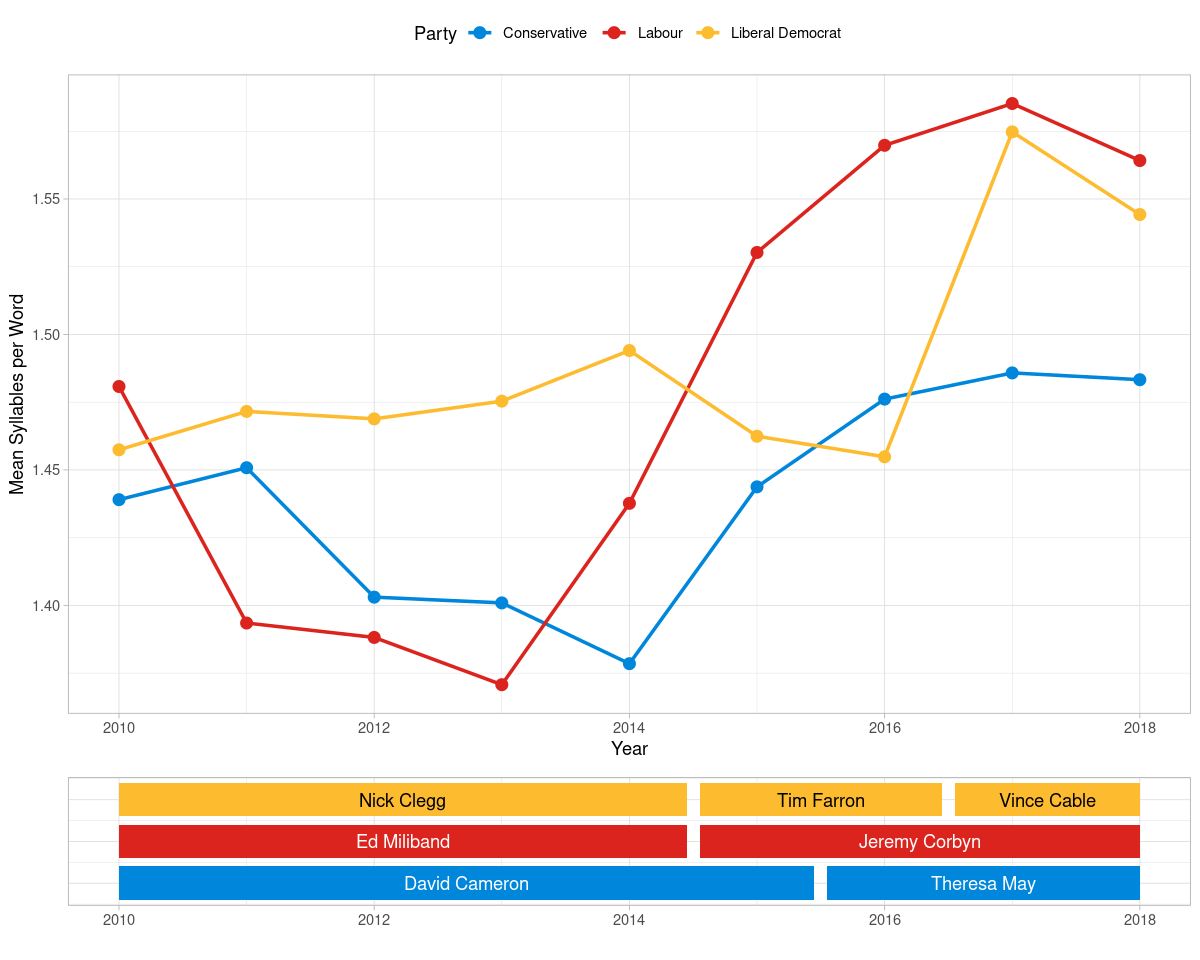

In [37]:
options(repr.plot.width = 10, repr.plot.height = 8)

syllables_plot <- speeches_readability %>%
  ggplot(aes(x = year, y = meanWordSyllables, col = party)) +
    geom_point(size = 3) +
    geom_line(size = 1) +
    labs(
        x = "Year",
        y = "Mean Syllables per Word",
        col = "Party"
    ) +
    scale_colour_manual(values = party_colours) +
    theme(legend.position = 'top')

ggarrange(syllables_plot, timeline, ncol = 1, nrow = 2, heights = c(0.8, 0.2), align = 'v')

We can see profound variations between different leaders in this plot. Ed Miliband and David Cameron, the leaders of Labour and the Conservatives who gave speeches between 2010-2014 and 2010-2015, respectively, had a much lower complexity than the most recent leaders such as Jeremy Corbyn of Labour and Vince Cable of the Liberal Democrats, who together count for the top 6 most complex speeches.

### A Different Way of Deciding Elections?

The [First Past the Post system](https://www.electoral-reform.org.uk/voting-systems/types-of-voting-system/first-past-the-post/) is often bemoaned in the UK as being unsuitable for modern-day politics. Now, it is not my place to comment on this system but if pushed to suggest another system, the aforementioned `Quanteda` package does give us another option...

We can calculate the mean scrabble score per word of the leader's party conference speech each year! First let us observe the most impressive efforts that the politicians managed:

In [38]:
speeches_scrabble <- speeches_words$word %>%
    textstat_readability("Scrabble") %>%
    as_tibble() %>%
    select(-document) %>%
    bind_cols(speeches_words, .) %>%
    mutate(scrabble_score = round(Scrabble * nchar(word))) %>%
    select(-Scrabble)

Warning message in nsentence.character(x):
“nsentence() does not correctly count sentences in all lower-cased text”


In [39]:
speeches_scrabble %>%
    arrange(desc(scrabble_score)) %>%
    head(5) %>%
    clean_names('title')

Party,Year,Leader,Word,Scrabble Score
<chr>,<int>,<chr>,<chr>,<dbl>
Conservative,2018,Theresa May,czechoslovakia,37
Liberal Democrat,2013,Nick Clegg,unequivocally,30
Labour,2017,Jeremy Corbyn,overwhelmingly,29
Labour,2017,Jeremy Corbyn,democratization,29
Labour,2015,Jeremy Corbyn,fizzing,29


Theresa May managed an incredible score of 37 in 2018 with 'Czechoslovakia' but this would of course be disqualified for being a proper noun. As a result, Nick Clegg holds the record with 30 points scored for 'unequivocally'! We can also visualise the mean score per word as follows.

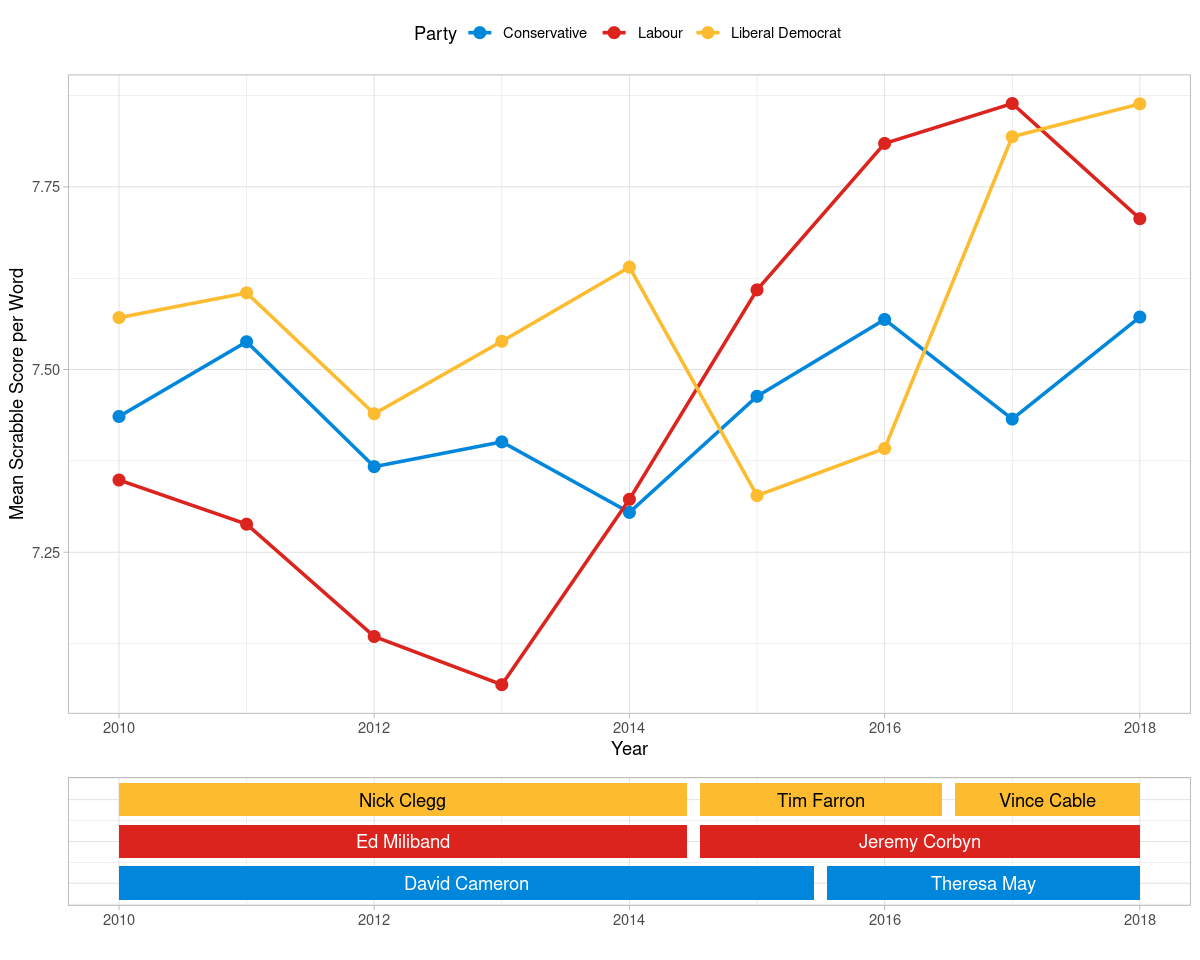

In [40]:
options(repr.plot.width = 10, repr.plot.height = 8)

scrabble_plot <- speeches_scrabble %>%
  group_by(party, year) %>%
  summarise(avg_score = mean(scrabble_score, na.rm = TRUE),
            .groups = 'drop') %>%
  ggplot(aes(x = year, y = avg_score, col = party)) +
    geom_point(size = 3) +
    geom_line(size = 1) +
    labs(
        x = "Year",
        y = "Mean Scrabble Score per Word",
        col = "Party"
    ) +
    scale_colour_manual(values = party_colours) +
    theme(legend.position = 'top')

ggarrange(scrabble_plot, timeline, ncol = 1, nrow = 2, heights = c(0.8, 0.2), align = 'v')

As we can see, the Conservatives, who have been in power since 2010 would not win a single year should it be decided by Scrabble. In fact, the Liberal Democrats would win 6 out of the 9 years we have studied with Labour, under Jeremy Corbyn, taking the other 3 years—I'm sure both parties would be happy with that in hindsight!

Just in case anyone was under any illusion, of course mean Scrabble score is a poor way of deciding elections and I am not endorsing its use—at the very least, a game of Pictionary would be more appropriate...

## Takeaways

With that, I end my brief incursion into British political speeches. While I have barely begun to scratch the surface of Natural Language Processing (NLP) methods, I hope that I have shown the power of the ways that these techniques can be used to summarise large pieces of text through sentiment, TF-IDF and syllable complexity. 

I had minimal experience with NLP methods upon embarking on this project and would like to thank WDSS (in particular, Janique Krasnowska) for supporting me until completion. I feel like I've learned a lot and certainly furthered my knowledge and experience. I would suggest anyone who would like to conduct some data science studies outside their degree looks out for research opportunites with WDSS and seizes them with both hands—I will certainly be looking out for more chances!

## Appendix: Summary Table of All Speech Metrics

In [41]:
reduce(list({
    # Word counts
    speeches_words %>%
        count(party, year, name = 'Number of Words')
}, {
    # Sentiment
    speeches_sentiment %>%
        group_by(party, year) %>%
        summarise(mean_sentiment = mean(value), .groups = 'drop')
}, {
    # TF-IDF
    speeches_top_word %>%
        select(party, year, `tfidf` = word)
},{
    # Mean syllables
    speeches_readability
}, {
    # Scrabble score
    speeches_scrabble %>%
        group_by(party, year) %>%
        summarise(mean_scrabble_score = mean(scrabble_score, na.rm = TRUE),
                  .groups = 'drop')
}), full_join, by = c('party', 'year')) %>%
    clean_names('title') %>%
    rename('Top TF-IDF Word' = Tfidf) %>%
    select(Party, Year, Leader, everything())

Party,Year,Leader,Number of Words,Mean Sentiment,Top TF-IDF Word,Mean Word Syllables,Mean Scrabble Score
<chr>,<int>,<chr>,<int>,<dbl>,<chr>,<dbl>,<dbl>
Conservative,2010,David Cameron,6247,0.38866397,harry,1.439020,7.435761
Conservative,2011,David Cameron,6132,0.40983607,euro,1.450808,7.538034
Conservative,2012,David Cameron,6070,0.47016706,rise,1.403032,7.367087
Conservative,2013,David Cameron,5917,0.45477387,finish,1.400913,7.401018
Conservative,2014,David Cameron,6104,0.49638554,40p,1.378480,7.304463
Conservative,2015,David Cameron,6676,0.45546559,extremism,1.443745,7.463356
Conservative,2016,Theresa May,7187,0.88888889,plays,1.476137,7.568521
Conservative,2017,Theresa May,7113,0.63288719,dream,1.485799,7.432207
Conservative,2018,Theresa May,7120,0.54709419,proposal,1.483296,7.571831
